In [65]:
# importing libraries
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import sys
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

stock_name = 'TSLA'
stock_data = pdr.get_data_tiingo(stock_name, api_key='a11bde55bb2d6793161fd75a059757be89231ad2')
csv_name = 'Dataset/'+stock_name+'.csv'
stock_data.to_csv(csv_name)
df = pd.read_csv(csv_name, parse_dates=True, usecols=['date', 'close'], na_values=['nan'])
df['date'] = (pd.to_datetime(df['date'])).astype('int64')/1000000000
df.tail()

,date,close
1253,1.595203e+09,1643.00
1254,1.595290e+09,1568.36
1255,1.595376e+09,1592.33
1256,1.595462e+09,1513.07
1257,1.595549e+09,1417.00


In [66]:
np.random.seed(7)

#df = df_stock
pd.options.mode.chained_assignment = None
#df.head()
#df = df.iloc[(len(df['close'])*4//5 ) : (len(df['close'])), :]
#print(df)
#print(df.shape)
#dataset = df.values
#print(dataset)
#dataset = dataset.astype('float32')
#print(dataset)
# normalize the dataset
scaler_date = MinMaxScaler(feature_range=(0, 1))
scaler_close = MinMaxScaler(feature_range=(0, 1))
df['date'] = scaler_date.fit_transform(df['date'])
df['close'] = scaler_close.fit_transform(df['close'])

dataset = df.values

# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

ValueError: Expected 2D array, got 1D array instead:
array=[1.4380416e+09 1.4381280e+09 1.4382144e+09 ... 1.5953760e+09 1.5954624e+09
 1.5955488e+09].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [56]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
 - 3s - loss: 0.0431
Epoch 2/100
 - 2s - loss: 0.0066
Epoch 3/100
 - 2s - loss: 1.1842e-04
Epoch 4/100
 - 1s - loss: 8.1754e-06
Epoch 5/100
 - 1s - loss: 7.0800e-06
Epoch 6/100
 - 1s - loss: 6.1204e-06
Epoch 7/100
 - 2s - loss: 5.6677e-06
Epoch 8/100
 - 2s - loss: 5.5292e-06
Epoch 9/100
 - 2s - loss: 5.7855e-06
Epoch 10/100
 - 2s - loss: 6.0559e-06
Epoch 11/100
 - 2s - loss: 6.8809e-06
Epoch 12/100
 - 2s - loss: 6.8106e-06
Epoch 13/100
 - 2s - loss: 7.3892e-06
Epoch 14/100
 - 2s - loss: 6.4190e-06
Epoch 15/100
 - 2s - loss: 6.8537e-06
Epoch 16/100
 - 2s - loss: 6.8957e-06
Epoch 17/100
 - 2s - loss: 6.2644e-06
Epoch 18/100
 - 2s - loss: 6.6552e-06
Epoch 19/100
 - 2s - loss: 6.8303e-06
Epoch 20/100
 - 2s - loss: 6.5633e-06
Epoch 21/100
 - 2s - loss: 6.2061e-06
Epoch 22/100
 - 2s - loss: 5.9721e-06
Epoch 23/100
 - 2s - loss: 5.8484e-06
Epoch 24/100
 - 2s - loss: 5.8271e-06
Epoch 25/100
 - 2s - loss: 5.7830e-06
Epoch 26/100
 - 2s - loss: 5.7643e-06
Epoch 27/100
 - 2s - loss: 5.

ValueError: non-broadcastable output operand with shape (941,1) doesn't match the broadcast shape (941,2)

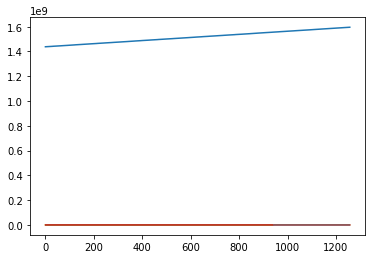

In [55]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [124]:
from numpy import newaxis

def plot_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.show()
    
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
testX.shape()
predictions = predict_sequences_multiple(model, testX[0], predict_length)
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
plot_results_multiple(predictions, testY, predict_length)

TypeError: 'tuple' object is not callable